In this example, we will be plotting both the flare location (flloc) and peak location (peak_loc) variables from
the flare location product. Flare location is an intensity-weighted centroid of all flaring region pixels, whereas peak location is the brightest pixel of the combined flaring and bright regions.

We will plot both flloc and peak_loc for each of the following coordinate systems:
 * Heliographic Stonyhurst `(longitude, latitude)`
 * Helioprojective Cartesian `(x arcsec, y arcsec)`


If you're having trouble getting this notebook to run, try these commands, and then run the import cell below:
* `conda create -n SDO_workshop_SUVI`
* `conda activate SDO_workshop_SUVI`
* `conda install jupyter sunpy netCDF4` or `conda install jupyter sunpy netCDF4 matplotlib astropy`

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import glob
import netCDF4 as nc
import os
import sunpy
import sunpy.map
import astropy.units as u
from astropy.coordinates import SkyCoord, CylindricalRepresentation
from sunpy.coordinates import frames
from sunpy.net import Fido, attrs as a
from astropy.io import fits
import matplotlib.cm as cm

For this example, we'll be looking at GOES-16 for 2024-01-23 3:44 UTC. We'll use the 131Å channel, since both 094Å and 131Å are best for visualizing flares.

In [2]:
goes = 16
date = datetime(2024, 1, 23, 3, 44)
wavelength = 131

Here, we'll define a couple helper functions - one to help add a better legend to our plots, and one to convert the SUVI flare location time to datetime.

In [3]:
def legend_handles():
    markers=['o', '*']
    fillstyle=['none', 'full']
    labels = ['flloc', 'peak_loc']
    f = lambda m,c,fill: plt.plot([],[],marker=m, color=c, ls='none', fillstyle=fill)[0]
    handles = [f(markers[i], 'k', fillstyle[i]) for i in range(len(markers))]
    return handles, labels

In [4]:
def convert_suvi_flloc_time(ftime):
    date_suvi_flloc = datetime(2000, 1, 1, 12, 0)
    date = date_suvi_flloc + timedelta(seconds=ftime)
    return date

This function will help us grab the background map of the sun for the time we requested. This searches +- 2 minutes from the time we request to get the closest possible map of the sun.

In [5]:
def create_suvi_sunpymap(date, goes=16, wavelength=131, rng=2):
    ds0 = (date - timedelta(minutes=rng)).strftime("%Y/%m/%d %H:%M:%S")
    ds1 = (date + timedelta(minutes=rng)).strftime("%Y/%m/%d %H:%M:%S")
    # Only search for L2 files from SUVI
    q = Fido.search(a.Time(ds0, ds1), a.Instrument.suvi, a.Wavelength(wavelength*u.angstrom), a.Level(2))
    tmp_files = Fido.fetch(q)
    # Select files from specified satellite
    for tmp_file in tmp_files:
        if (f'g{goes}' in tmp_file):
            data, header = fits.getdata(tmp_file, ext=1), fits.getheader(tmp_file, 1)
            suvi_map = sunpy.map.Map(data, header)
            return suvi_map, data, header

Let's load in a flare location file and take a look at the variables. The locations we'll be using are:
 * `flloc_hg`
 * `peak_loc_hg`
 * `flloc_hpc`
 * `peak_loc_hpc`

Be sure to change the path to wherever you downloaded the NetCDF file!

In [6]:
suvi_flloc_path = '/Users/elysia.lucas/Downloads/dr_suvi-l2-flloc_g16_s20240123T034400Z_e20240123T034800Z_v1-0-6.nc'
flloc_nc = nc.Dataset(suvi_flloc_path)
print(flloc_nc.variables.keys())

dict_keys(['time', 'wavelength', 'degraded_status', 'num_flloc', 'brght_area', 'srs_status', 'xrs_status', 'euv_status', 'flloc_pix', 'flloc_hg', 'flloc_car', 'flloc_rtheta', 'flloc_hpc', 'flloc_hcc', 'flloc_hcr', 'tot_flux', 'peak_flux', 'peak_loc_pix', 'peak_loc_hg', 'peak_loc_car', 'peak_loc_rtheta', 'peak_loc_hpc', 'peak_loc_hcc', 'peak_loc_hcr'])


The shape of these variables for our chosen coordinate systems is `(1, n, 6, 2)`.
* 1 = 1 time 
* n = n flare(s) recorded
* 6 = 6 wavelengths   
* 2 = 2 coordinate dimensions

As you can see, this file contains 2 flares, making the shape `(1, 2, 6, 2)`.
Below, you can see coordinate pairs per flare, per wavelength.

In [7]:
print('FLLOC HPC SHAPE:', np.shape(flloc_nc['flloc_hpc'][:]))
print('')
print(flloc_nc['flloc_hpc'][:])

FLLOC HPC SHAPE: (1, 2, 6, 2)

[[[[ 501.911 -235.57 ]
   [ 503.303 -236.632]
   [ 501.512 -234.692]
   [ 501.485 -235.153]
   [ 500.657 -234.871]
   [ 501.276 -235.302]]

  [[-272.757  561.57 ]
   [-271.408  562.239]
   [-272.852  559.842]
   [-272.748  560.147]
   [-272.802  560.175]
   [-272.728  559.808]]]]


Let's grab the time from the flare location file, and convert it to a regular datetime. Then, we will query via Fido and grab our SUVI SunPy map on which we can overlay coordinates.

In [9]:
flloc_time = convert_suvi_flloc_time(flloc_nc['time'][:][0])
suvi_map, suvi_data, suvi_header = create_suvi_sunpymap(date)

Files Downloaded:   0%|          | 0/2 [00:00<?, ?file/s]

First, we will plot the coordinates from the Heliographic Stonyhurst coordinate system.

This cell below first plots the SUVI SunPy Map as the background, then extracts the arrays for `flloc_hg` and `peak_loc_hg` from the NetCDF.

For each flare, it will make a SkyCoord object in the Heliographic Stonyhurst coordinate system, and then plot corresponding contours (crosshairs) to make the flares easier to pinpoint. Then, it will transform that SkyCoord object to correspond with the SUVI SunPy Map's coordinate system.

Heliographic Stonyhurst is only defined on-disk, so any off-disk coordinates will show as NaNs. This doesn't pertain to this example specifically, but is good to keep in mind when plotting flares in general.

Notes: 
 * The SunPy Map is Helioprojective, which is why the x/y labels are also Helioprojective.
 * Ignore "INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]" - this is due to an unfilled `RSUN_REF` metadata variable that will be included in future products.

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


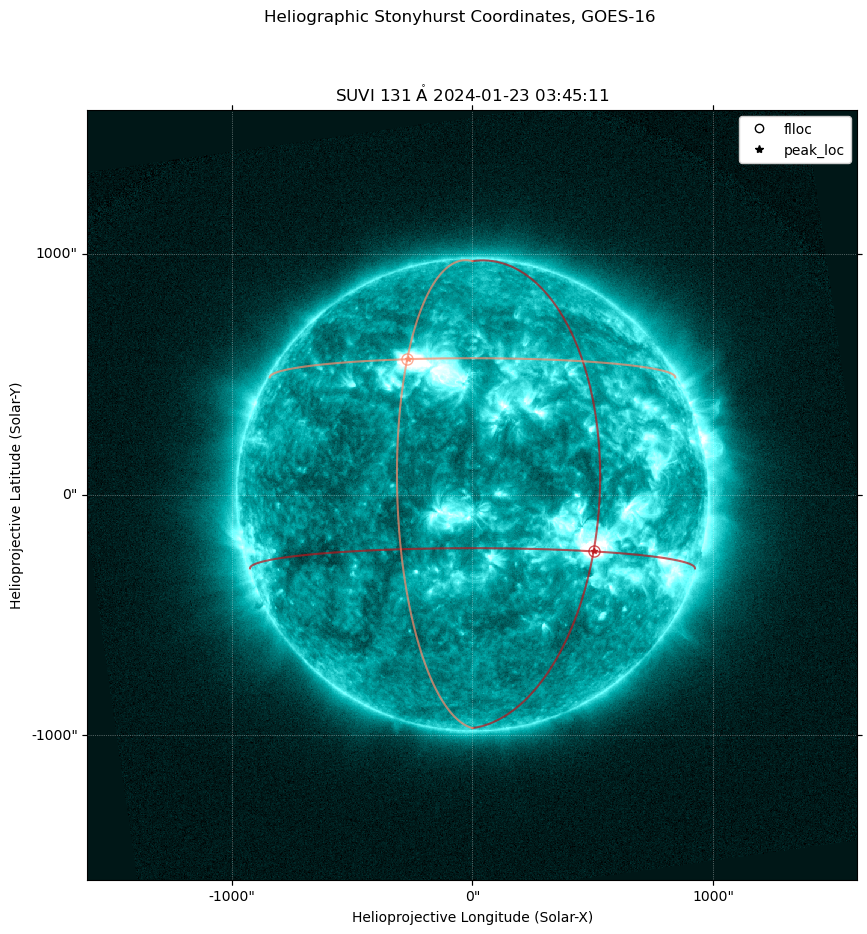

In [10]:
# Plot the composite image SunPy map
fig = plt.figure(figsize=(10, 10))
fig.tight_layout(h_pad=-50)
fig.suptitle(f'Heliographic Stonyhurst Coordinates, GOES-{goes}')
ax = fig.add_subplot(projection=suvi_map)
suvi_map.plot(axes=ax, clip_interval=(0.1, 99.9)*u.percent)
num_points = 100

# Get wavelength index of requested wavelength
wavelength_i = list(flloc_nc['wavelength'][:]).index(wavelength)

# Extract flare location from netCDF
flloc_hg = flloc_nc['flloc_hg'][:][0]
peak_hg = flloc_nc['peak_loc_hg'][:][0]

# Establish colormap (one distinct color per flare)
colors = cm.Reds_r(np.linspace(0.2, 0.6, len(flloc_hg)))

### For each flare location in flloc_hg, plot flare and contours
for flare, c in zip(flloc_hg, colors):

    x = flare[wavelength_i][0]
    y = flare[wavelength_i][1]

    # Convert flare location into SkyCoord object in Heliographic Stonyhurst frame
    flloc_hgs_sc = SkyCoord(x*u.degree, y*u.degree, obstime=flloc_time, observer=suvi_map.observer_coordinate, frame=frames.HeliographicStonyhurst)


    # Plot contours
    stonyhurst_frame = frames.HeliographicStonyhurst(obstime=suvi_map.date)
    constant_lon = SkyCoord(flloc_hgs_sc.lon, np.linspace(-90, 90, num_points) * u.deg,
                            frame=stonyhurst_frame)
    constant_lat = SkyCoord(np.linspace(-90, 90, num_points) * u.deg, flloc_hgs_sc.lat,
                            frame=stonyhurst_frame)
    
    ax.plot_coord(constant_lon, color=c, alpha=0.7)
    ax.plot_coord(constant_lat, color=c, alpha=0.7)

     # Transform SkyCoord object to the SUVI SunPy Map's coordinate frame
    flloc_hgs_sc = flloc_hgs_sc.transform_to(suvi_map.coordinate_frame)

    # Plot flare
    ax.plot_coord(flloc_hgs_sc, color=c, marker='o', fillstyle='none', markersize=8, alpha=0.7)

### For each flare location in peak_loc_hg, plot flare
for flare, c in zip(peak_hg, colors):
    flare[flare == -9999.] = np.nan
    flare = flare.filled(fill_value=np.nan)
    wavelength_i = list(flloc_nc['wavelength'][:]).index(wavelength)

    x = flare[wavelength_i][0]
    y = flare[wavelength_i][1]

    # Convert flare location into SkyCoord object in Heliographic Stonyhurst frame
    flloc_hgs_sc = SkyCoord(x*u.degree, y*u.degree, obstime=flloc_time, observer=suvi_map.observer_coordinate, frame=frames.HeliographicStonyhurst)

     # Transform SkyCoord object to the SUVI SunPy Map's coordinate frame
    flloc_hgs_sc = flloc_hgs_sc.transform_to(suvi_map.coordinate_frame)

    # Plot flare
    ax.plot_coord(flloc_hgs_sc, color=c, marker='*', markersize=4, alpha=0.85)

# Add legend for features
handles, labels = legend_handles()    
plt.legend(handles, labels, loc=1, framealpha=1)

plt.show()

Now, we will plot the coordinates from the Helioprojective Cartesian coordinate system.

This cell below first plots the SUVI SunPy Map as the background, then extracts the arrays for `flloc_hg` and `peak_loc_hg` from the NetCDF.

For each flare, it will make a SkyCoord object in the Helioprojective Cartesian coordinate system, and then plot corresponding contours (crosshairs) to make the flares easier to pinpoint.

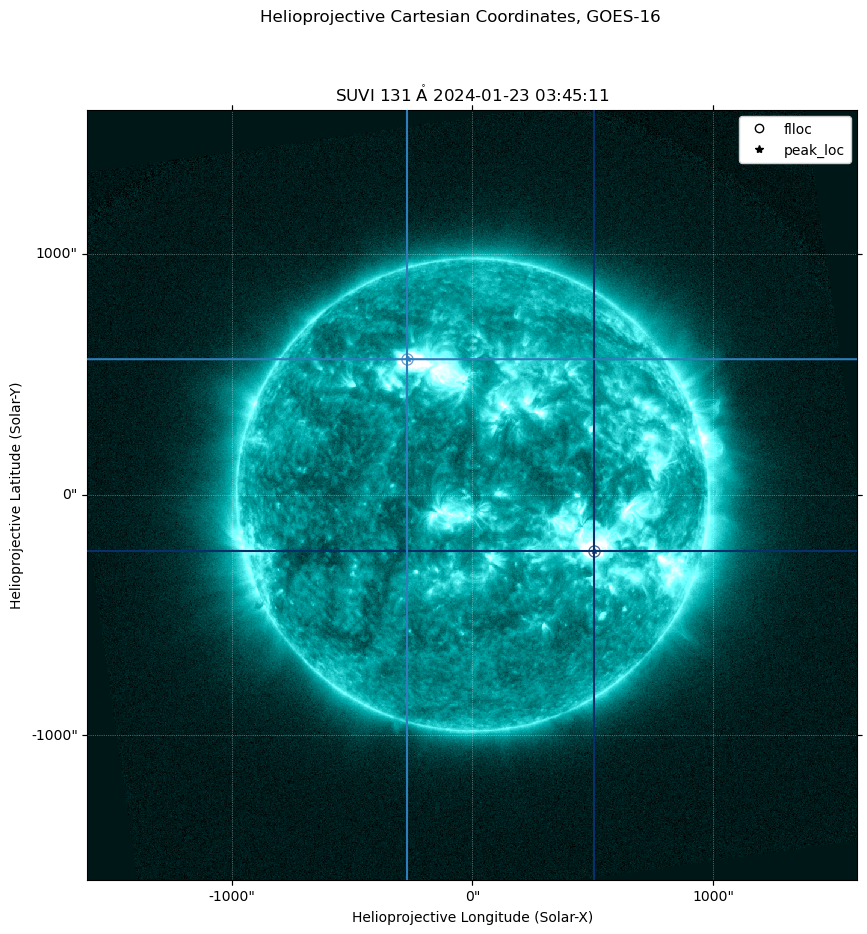

In [11]:
# Plot the composite image SunPy map
fig = plt.figure(figsize=(10, 10))
fig.tight_layout(h_pad=-50)
fig.suptitle(f'Helioprojective Cartesian Coordinates, GOES-{goes}')
ax = fig.add_subplot(projection=suvi_map)
suvi_map.plot(axes=ax, clip_interval=(0.1, 99.9)*u.percent)
num_points = 100

x_limits = ax.get_xlim()
y_limits = ax.get_ylim()

# Get wavelength index of requested wavelength
wavelength_i = list(flloc_nc['wavelength'][:]).index(wavelength)

# Extract flare location from netCDF
flloc_hpc = flloc_nc['flloc_hpc'][:][0]
peak_hpc = flloc_nc['peak_loc_hpc'][:][0]

# Establish colormap (one distinct color per flare)
colors = cm.Blues_r(np.linspace(0., 0.3, len(flloc_hpc)))

### For each flare location in flloc_hpc, plot flare and contours
for flare, c in zip(flloc_hpc, colors):
    x = float(flare[wavelength_i][0])
    y = float(flare[wavelength_i][1])
    
    # Convert flare location into SkyCoord object in Helioprojective frame
    flloc_hpc_sc = SkyCoord(x*u.arcsec, y*u.arcsec, obstime=flloc_time, observer=suvi_map.observer_coordinate, frame=frames.Helioprojective)

    # Set params
    line_resolution = 100
    
    # Draw x-crosshairs
    x_location = np.repeat(x, line_resolution) * u.arcsec
    y_line = np.linspace(-1600,1600, line_resolution) * u.arcsec
    # Draw y-crosshairs
    y_location = np.repeat(y, line_resolution) * u.arcsec
    x_line = np.linspace(-1600,1600, line_resolution) * u.arcsec

    ax.plot(x_line.to(u.deg), y_location.to(u.deg), color=c, transform=ax.get_transform("world"))
    ax.plot(x_location.to(u.deg), y_line.to(u.deg), color=c, transform=ax.get_transform("world"))
   
    # Plot flare
    ax.plot_coord(flloc_hpc_sc, color=c, marker='o', fillstyle='none', markersize=8, alpha=0.7)

### For each flare location in peak_loc_hpc, plot flare and contours
for flare, c in zip(peak_hpc, colors):
    x = float(flare[wavelength_i][0])
    y = float(flare[wavelength_i][1])
    
    # Convert flare location into SkyCoord object in Helioprojective frame
    flloc_hpc_sc = SkyCoord(x*u.arcsec, y*u.arcsec, obstime=flloc_time, observer=suvi_map.observer_coordinate, frame=frames.Helioprojective)

    # Plot flare
    ax.plot_coord(flloc_hpc_sc, color=c, marker='*', markersize=4, alpha=0.85)

# Add legend for features
handles, labels = legend_handles()    
plt.legend(handles, labels, loc=1, framealpha=1)
ax.set_xlim(x_limits)
ax.set_ylim(y_limits)

plt.show()

You've now successfully plotted `flloc` and `peak_loc` for two commonly used solar coordinate systems! For more coordinate system examples, or examples of our other products, check out our website:

https://cires-stp.github.io/goesr-spwx-examples/examples/index.html#suvi